In [1]:
import numpy as np
import scipy

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys, gc
import skimage

plt.style.use('ggplot')
sys.path.insert(0,'..') # add parent directory to path
import utils

# this is important to make sure the Config is reloaded when modified
%load_ext autoreload
%autoreload 2
# %pprint

In [2]:
all_res = utils.load_object('../cam/all_res.pkl')
all_map = utils.load_object('../cam/all_map.pkl')
all_inv_map = utils.load_object('../cam/all_inv_map.pkl')

In [3]:
def overlay_heatmap(org_img, heatmap, gauss_sigma=None, thresh=None, normalize=False, absolute=False):
    img = org_img/255
    if absolute:
        heatmap = np.abs(heatmap)
    
    if thresh:
        heatmap[heatmap < thresh] = 0
    
    if normalize:
        heatmap = utils.normalize(heatmap)
        
#     print(np.min(heatmap), np.max(heatmap))
    if gauss_sigma is not None:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma=gauss_sigma)
    
    if not normalize:
        heatmap = heatmap / 40
    
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    
    if normalize:
        pass
    else:
        if absolute:
            plt.clim(0,1)
        else:
            plt.clim(-1,1)
    
    colorbar = plt.colorbar()
#     print(colorbar)
#     plt.show()
    
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.5
    

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img, colorbar

def print_proba_seq_results(proba_res, class_to_name_dict):
    for key, value in proba_res.items():
        print(key)
        print_proba_results(value, class_to_name_dict)
            
def print_proba_results(proba_res, class_to_name_dict):
    for i, proba in enumerate(proba_res):
        print(class_to_name_dict[proba[0]], proba[1])

In [54]:
keys_to_vis = ['ground_truth', 'first_prob', 'second_prob', 'correct', 'soft_heatmap']

key_to_title = {
    'ground_truth': 'Human attention - ground truth',
    'first_prob': 'CAM: Model\'s prediction (highest probability)',
    'second_prob': 'CAM: Model\'s second highest probability',
    'correct': 'CAM: Ground truth class',
    'soft_heatmap': 'Soft attention: heatmap'
}

def visualize(name, heatmap_results_list, class_map, save=False):    
    hm_results = heatmap_results_list[name]
    print("CAM prediction results:")
    print_proba_results(hm_results['prob_res'], class_map)
    
    print('')
    
    print("Soft attention prediction results:")
    print_proba_results(hm_results['soft_prob_res']['c'], class_map)
    
    for key in keys_to_vis:
        plt.figure()
        print('-------')
        print(key_to_title[key])
        hm_result = hm_results[key]
        heatmap = np.asarray(hm_result['hm'], np.float32)
        
        normalize=False
        if np.max(heatmap) < 1:
            normalize=True
        
        img, colorbar = overlay_heatmap(hm_results['image'], heatmap, 
                                        normalize=(normalize), absolute=True)
        plt.imshow(img, cmap='jet')

        # plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        
        if not save:
            plt.show()
        else:
            plt.savefig('./images/' + name.replace('.jpg', '') + '_' + key + '.jpg', bbox_inches='tight')
        
        if key == 'first_prob':
            print("Visualizing for:", class_map[hm_results['prob_res'][0][0]])
        elif key == 'second_prob':
            print("Visualizing for:", class_map[hm_results['prob_res'][1][0]])
        elif key == 'correct':
            for res in hm_results['prob_res']:
                class_n, prob = res
                if class_map[class_n] == name.split('_')[0]:
                    print("Visualizing for:", class_map[class_n])
        
        if key != 'ground_truth':
            print("Perason correlation with ground truth:", hm_result['pcc'])
        
        print('')
        
    

In [5]:
cam_res = {name: value['cam_res'] for name, value in all_res.items()}
soft_res = {name: value['soft_res'] for name,value in all_res.items()}
# print(soft_res[name].keys())

for name, name_entries in soft_res.items():
    for step, att_dict in name_entries['attention_vis'].items():
        computer_img = att_dict['human'].copy()
        human_img = att_dict['computer'].copy()
        att_dict['human'] = human_img
        att_dict['computer'] = computer_img
            

In [12]:
highest_pcc = 0
highest_pcc_name = ''
highest_is_cam = True
lowest_pcc = 1
lowest_pcc_name = ''
lowest_is_cam = True
for name, name_entries in cam_res.items():
    soft_pcc = soft_res[name]['avg_heatmap']['pcc']
    cam_pcc = cam_res[name]['first_prob']['pcc']
    if soft_pcc > highest_pcc:
        highest_pcc_name = name
        highest_pcc = soft_pcc
#         if soft_pcc > cam_pcc:
#             highest_is_cam = False
#             highest_pcc = cam_pcc
        
    if soft_pcc < lowest_pcc:
        lowest_pcc_name = name
        lowest_pcc = soft_pcc
#         if soft_pcc < cam_pcc:
#             lowest_is_cam = False
#             lowest_pcc = soft_pcc

In [18]:
names = []
for name, name_entries in cam_res.items():
    names.append(name)
len(names)

100

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('softstat.csv', index_col=0)
df.head()

,id,true_class,soft_prediction,soft_certainty,soft_pcc,soft_all_probas
0,dog_2008_003665.jpg,dog,dog,0.627715,0.089912,"[('dog', 0.6277153), ('cat', 0.13424954), ('ho..."
1,dog_2011_001543.jpg,dog,cat,0.671896,0.049949,"[('cat', 0.67189634), ('dog', 0.26952815), ('c..."
2,dog_2010_000395.jpg,dog,cat,0.972907,0.449007,"[('cat', 0.9729066), ('dog', 0.014079208), ('h..."
3,dog_2008_004647.jpg,dog,dog,0.432034,0.249341,"[('dog', 0.43203354), ('horse', 0.21311668), (..."
4,dog_2009_000600.jpg,dog,dog,0.959290,0.276240,"[('dog', 0.95928985), ('cow', 0.023589429), ('..."


In [37]:
misclas_examples = ['bicycle_2008_004482.jpg', 'dog_2011_001543.jpg', 'cat_2008_006294.jpg']

In [23]:
soft_df = df[df['id'].isin(names)]

In [29]:
soft_misclas_ids = soft_df[soft_df['true_class'] != soft_df['soft_prediction']]['id']

In [25]:
df = pd.read_csv('../cam/camstat.csv', index_col=0)
cam_df = df[df['id'].isin(names)]

In [32]:
cam_misclas_ids = cam_df[cam_df['true_class'] != cam_df['cam_prediction']]['id']

In [36]:
cam_misclas_ids

23       aeroplane_2008_004348.jpg
127            dog_2011_001543.jpg
147            dog_2008_002395.jpg
206            dog_2008_008714.jpg
261        bicycle_2008_004482.jpg
277        bicycle_2011_002281.jpg
297            cat_2008_006294.jpg
318            cat_2008_002623.jpg
361            cat_2010_004816.jpg
382            cat_2011_003216.jpg
416            cow_2009_002869.jpg
422            cow_2008_002709.jpg
429            cow_2008_007123.jpg
436    diningtable_2009_000247.jpg
446    diningtable_2011_000530.jpg
454    diningtable_2011_002924.jpg
466    diningtable_2011_002640.jpg
478          horse_2009_003725.jpg
488          horse_2008_002835.jpg
492          horse_2008_008232.jpg
512          horse_2011_000594.jpg
564      motorbike_2008_006152.jpg
575      motorbike_2008_004554.jpg
577           sofa_2009_003656.jpg
594           sofa_2011_000820.jpg
606           sofa_2010_003804.jpg
Name: id, dtype: object

In [35]:
soft_misclas_ids

1              dog_2011_001543.jpg
2              dog_2010_000395.jpg
8              dog_2010_004749.jpg
9              dog_2008_008714.jpg
131      aeroplane_2008_004348.jpg
244        bicycle_2008_005553.jpg
246        bicycle_2011_002281.jpg
247        bicycle_2008_004482.jpg
252        bicycle_2010_003446.jpg
299            cat_2008_006294.jpg
303            cat_2010_003598.jpg
401            cow_2010_003345.jpg
404            cow_2008_002709.jpg
408            cow_2008_007123.jpg
409            cow_2011_001840.jpg
410            cow_2009_002708.jpg
432    diningtable_2009_004263.jpg
435    diningtable_2011_002994.jpg
438    diningtable_2011_002640.jpg
439    diningtable_2011_002924.jpg
479          horse_2009_003725.jpg
487          horse_2009_002182.jpg
527      motorbike_2008_006152.jpg
578           sofa_2011_000820.jpg
580           sofa_2009_003656.jpg
583           sofa_2010_003804.jpg
Name: id, dtype: object

In [42]:
cam_df[cam_df['id'].isin(misclas_examples)]

,id,true_class,cam_prediction,cam_certainty,cam_first_prob_pcc,cam_second_prob_pcc,cam_true_class_pcc,cam_all_probas
127,dog_2011_001543.jpg,dog,cat,0.785344,0.019151,0.298514,0.298514,"[('cat', 0.78534365), ('dog', 0.19839223), ('c..."
261,bicycle_2008_004482.jpg,bicycle,motorbike,0.904778,-0.068087,-0.146779,0.360648,"[('motorbike', 0.9047778), ('horse', 0.0530490..."
297,cat_2008_006294.jpg,cat,dog,0.911219,0.315582,0.319330,-0.044663,"[('dog', 0.91121876), ('horse', 0.06882809), (..."


In [43]:
soft_df[soft_df['id'].isin(misclas_examples)]

,id,true_class,soft_prediction,soft_certainty,soft_pcc,soft_all_probas
1,dog_2011_001543.jpg,dog,cat,0.671896,0.049949,"[('cat', 0.67189634), ('dog', 0.26952815), ('c..."
247,bicycle_2008_004482.jpg,bicycle,motorbike,0.687476,0.297121,"[('motorbike', 0.6874757), ('bicycle', 0.26276..."
299,cat_2008_006294.jpg,cat,horse,0.354462,-0.075463,"[('horse', 0.35446247), ('dog', 0.24461699), (..."


CAM prediction results:
cat 0.78534365
dog 0.19839223
cow 0.013434678
horse 0.002455594
sofa 0.00019402953
motorbike 9.469502e-05
aeroplane 4.4494376e-05
diningtable 2.8585917e-05
boat 1.1771376e-05
bicycle 2.0236628e-07

Soft attention prediction results:
cat 0.67189634
dog 0.26952815
cow 0.0273471
horse 0.022087788
diningtable 0.0037564728
sofa 0.002374566
boat 0.002049806
motorbike 0.00067645276
bicycle 0.0001841455
aeroplane 9.915589e-05
-------
Human attention - ground truth

-------
CAM: Model's prediction (highest probability)


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Visualizing for: cat
Perason correlation with ground truth: 0.01915068601362735

-------
CAM: Model's second highest probability
Visualizing for: dog
Perason correlation with ground truth: 0.29851376780047256

-------
CAM: Ground truth class
Visualizing for: dog
Perason correlation with ground truth: 0.29851376780047256

-------
Soft attention: heatmap
Perason correlation with ground truth: 0.049949042015008764



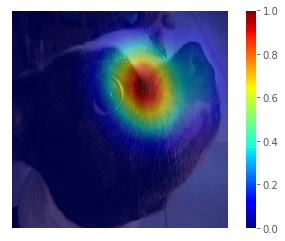

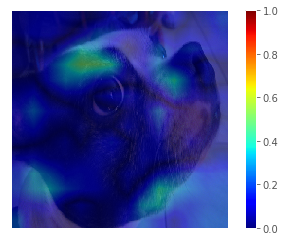

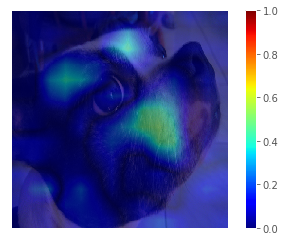

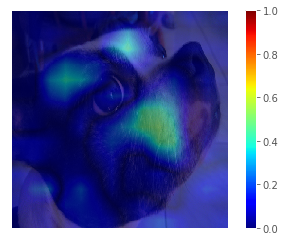

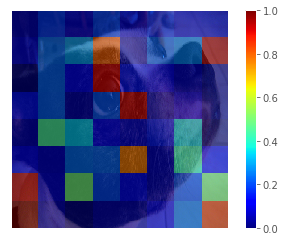

In [62]:
visualize(misclas_examples[1], cam_res, all_inv_map, save=True)

In [13]:
highest_pcc_name, lowest_pcc_name

('motorbike_2008_004554.jpg', 'bicycle_2009_000573.jpg')

CAM prediction results:
bicycle 0.52179044
dog 0.22062919
horse 0.11151872
motorbike 0.08538841
aeroplane 0.040061295
cat 0.008403372
boat 0.007386389
sofa 0.0023628399
cow 0.002061562
diningtable 0.000397789

Soft attention prediction results:
motorbike 0.6476883
bicycle 0.32690316
diningtable 0.008605966
aeroplane 0.005034256
dog 0.0028951056
sofa 0.0028296162
boat 0.0028041413
horse 0.0025862898
cow 0.00057619746
cat 7.696324e-05
-------
Human attention - ground truth


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


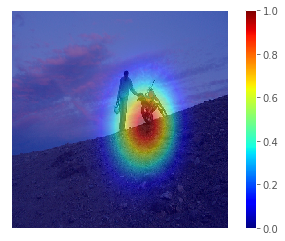


-------
CAM: Model's prediction (highest probability)


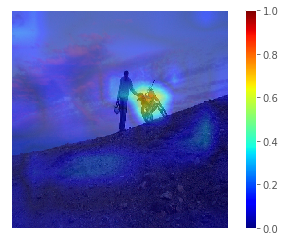

Visualizing for: bicycle
Perason correlation with ground truth: 0.43427636127378955

-------
CAM: Model's second highest probability


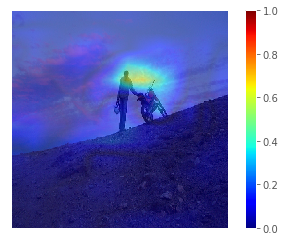

Visualizing for: dog
Perason correlation with ground truth: 0.31715868171849326

-------
CAM: Ground truth class


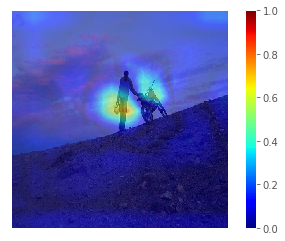

Visualizing for: motorbike
Perason correlation with ground truth: 0.3239584054041912

-------
Soft attention: heatmap


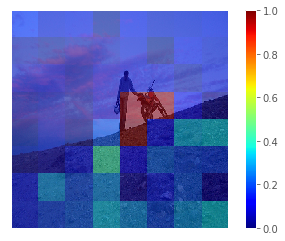

Perason correlation with ground truth: 0.6339619856427481



In [14]:
visualize(highest_pcc_name, cam_res, all_inv_map)

CAM prediction results:
aeroplane 0.99983037
boat 0.00010107423
dog 1.9047477e-05
motorbike 1.7029686e-05
bicycle 1.4523885e-05
diningtable 1.4226935e-05
horse 3.435414e-06
cat 8.5918494e-08
sofa 7.751303e-08
cow 5.721757e-08

Soft attention prediction results:
aeroplane 0.93813497
boat 0.045088813
motorbike 0.007334693
bicycle 0.005315444
horse 0.0016120482
dog 0.0011533909
diningtable 0.0005088223
sofa 0.00038883314
cow 0.0003601627
cat 0.00010289001
-------
Human attention - ground truth


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


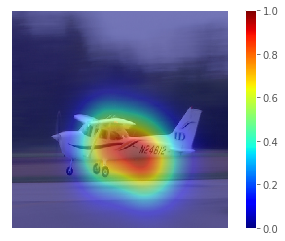


-------
CAM: Model's prediction (highest probability)


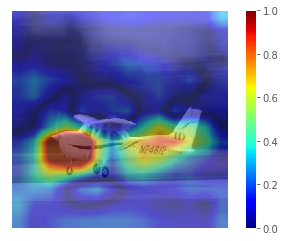

Visualizing for: aeroplane
Perason correlation with ground truth: 0.38003299934954676

-------
CAM: Model's second highest probability


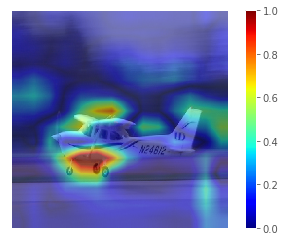

Visualizing for: boat
Perason correlation with ground truth: 0.2690754157959712

-------
CAM: Ground truth class


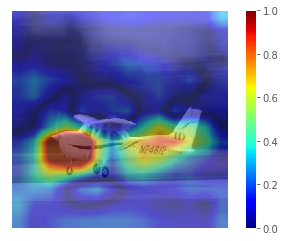

Visualizing for: aeroplane
Perason correlation with ground truth: 0.38003299934954676

-------
Soft attention: heatmap


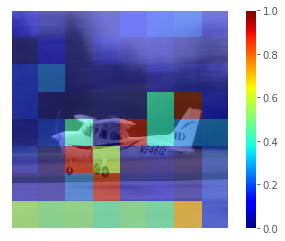

Perason correlation with ground truth: 0.20768018869444416



In [9]:
# add to cam_res to merge the heatmaps into one visualization
for key, value in cam_res.items():
    cam_res[key]['soft_heatmap'] = soft_res[key]['avg_heatmap']
    cam_res[key]['soft_prob_res'] = soft_res[key]['prob_res']

name = list(all_res.keys())[0]
visualize(name, cam_res, all_inv_map)

In [10]:
attention_vis.keys()

NameError: name 'attention_vis' is not defined

a
boat 0.16316032
aeroplane 0.16223986
bicycle 0.12646219
sofa 0.11340818
horse 0.097390756
diningtable 0.09560565
dog 0.06972207
motorbike 0.06623564
cow 0.055014066
cat 0.050761238
computer


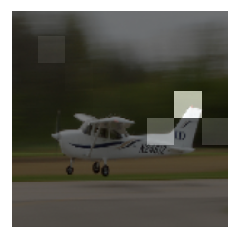

human


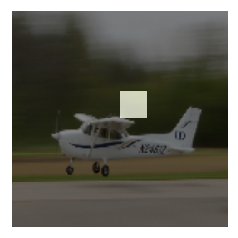

b
aeroplane 0.14606461
boat 0.1313717
dog 0.12286977
horse 0.11602451
cow 0.105176896
sofa 0.10376384
cat 0.07420742
bicycle 0.06845204
motorbike 0.06645159
diningtable 0.06561761
computer


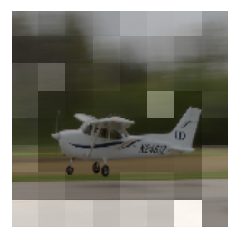

human


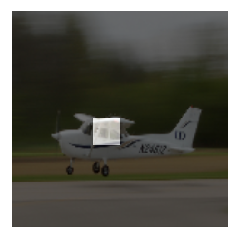

c
aeroplane 0.93813497
boat 0.045088813
motorbike 0.007334693
bicycle 0.005315444
horse 0.0016120482
dog 0.0011533909
diningtable 0.0005088223
sofa 0.00038883314
cow 0.0003601627
cat 0.00010289001
computer


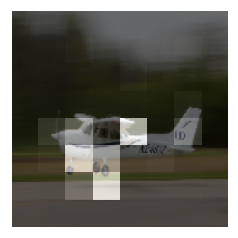

human


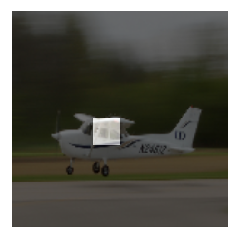

In [11]:
attention_vis = soft_res[name]['attention_vis']

for step, att_dict in attention_vis.items():
    print(step)
    print_proba_results(soft_res[name]['prob_res'][step], all_inv_map)
    for subject, img in att_dict.items():
        print(subject)
        plt.imshow(np.asarray(img, np.float32))
        plt.grid(False)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()